In [2]:
import json
import warnings
from gensim.models import word2vec
import networkx as nx
import matplotlib.pyplot as plt
import pymorphy2

analyzer = pymorphy2.MorphAnalyzer()
warnings.simplefilter('ignore')
%config InlineBackend.figure_format='retina'

### Приведем корпуса к структуре list[list[str]] для создания векторизованных представлений, лемматизируем все слова.
- Первый корпус - посты из двух сообществ ВК, посвященных медитации (314153 слова)
- Второй - также посты из сообщества, посвящен осознанным сновидениям (62149 слова)

In [3]:
def normalize(corpus_filename: str):
    with open(corpus_filename, 'r') as f:
        corpus = json.load(f)

    corpus_list = []
    for doc in corpus.values():
        norm_doc = [analyzer.parse(word)[0].normal_form for word in doc]
        corpus_list.append(norm_doc)

    with open(f'norm_{corpus_filename}', 'w') as f:
        json.dump(corpus_list, f, ensure_ascii=False)


normalize('tokenized_corpus5k.json')
normalize('tokenized_corpus.json')

### Корпус 'медитации'

In [4]:
with open('norm_tokenized_corpus5k.json', 'r') as f:
    base_corpus = json.load(f)
base_corpus[0][:10]

['остановка',
 'ум',
 'научиться',
 'останавливать',
 'ум',
 'нужно',
 'просто',
 'наблюдать',
 'мысль',
 'откуда']

In [8]:
base_model = word2vec.Word2Vec(base_corpus, workers=4, vector_size=300,
                               min_count=10, window=10, sample=1e-3)

### Оценим модель вручную. Результаты запросов отражают связи между словами, не противоречат содержанию постов в группе.
- Медитация в постах - это практика, длящаяся годами.
- Спокойствие и тревожность - ощущения, которые требуют внимания и наблюдения.
- Разница этих двух состояний - мысли, что в контексте медитаций есть чистая правда.
- Сфокусированное состояние, лишенное тревожности, позитивно.
- Разница суммы векторов слов 'мастер', 'практика' и вектора слова 'начинающий' равняется осознанности. От себя скажу, что именно это отличает медитацию опытного человека от новичка.

In [9]:
print(base_model.wv.most_similar('медитация', topn=3))
print(base_model.wv.most_similar('тело', topn=3))

print(base_model.wv.similarity('сложный', 'долгий'))
print(base_model.wv.similarity('дыхание', 'отвлекаться'))

[('практика', 0.9376958012580872), ('медитировать', 0.9257645606994629), ('год', 0.9105504751205444)]
[('ощущение', 0.9742224216461182), ('внимание', 0.9626272320747375), ('наблюдать', 0.9574379920959473)]
0.9937546
0.56594026


In [10]:
print(base_model.wv.most_similar(positive=['спокойствие'],
                                 negative=['тревожность'], topn=1)[0][0])
print(base_model.wv.most_similar(positive=['фокус', 'состояние'],
                                 negative=['тревожность'], topn=1)[0][0])

print(base_model.wv.most_similar(positive=['мастер', 'практика'],
                                 negative=['начинающий'], topn=1)[0][0])
print(base_model.wv.most_similar(positive=['настоящий', 'результат'],
                                 negative=['ошибка'], topn=1)[0][0])

мысль
позитивный
осознанность
сам


###  Дообучим модель на корпусе 'осознанные сновидения'

In [26]:
base_model_path = 'base_model.model'

base_model.save(base_model_path)
model = word2vec.Word2Vec.load(base_model_path)

with open('norm_tokenized_corpus.json', 'r') as f:
    add_corpus = json.load(f)

model.build_vocab(add_corpus, update=True)
model.train(add_corpus, total_examples=model.corpus_count, epochs=5)

(132208, 192860)

In [100]:
add_corpus[0][:10]

['миф',
 'обязательный',
 'вибрация',
 'выход',
 'тело',
 'практика',
 'вибрация',
 'это',
 'признак',
 'скорый']

### С включением корпуса 'осознанные сновидения' появились соответствующие слова.
- Избавление от тревожности в контексте осознанных сновидений по всей видимости связано с работой с сознанием
- Отличие мастера от новичка теперь не отражает специфики медитаций, и вместо осознанности решение примера - более общее слово "результат"

In [27]:
print(model.wv.most_similar('медитация', topn=3))
print(model.wv.most_similar('тело', topn=3))

print(model.wv.similarity('сложный', 'долгий'))
print(model.wv.similarity('дыхание', 'отвлекаться'))

[('практика', 0.9578226208686829), ('осознанность', 0.9438179135322571), ('курс', 0.9108596444129944)]
[('ощущение', 0.9955767393112183), ('часть', 0.9837309122085571), ('внимание', 0.9591270685195923)]
0.9354425
0.5011731


In [28]:

print(base_model.wv.most_similar(positive=['спокойствие'],
                                 negative=['тревожность'], topn=1)[0][0])
print(model.wv.most_similar(positive=['фокус', 'состояние'],
                            negative=['тревожность'], topn=1)[0][0])

print(model.wv.most_similar(positive=['мастер', 'практика'],
                            negative=['начинающий'], topn=1)[0][0])
print(model.wv.most_similar(positive=['настоящий', 'результат'],
                            negative=['ошибка'], topn=1)[0][0])

мысль
сознание
результат
вещий


In [29]:
model.init_sims(replace=True)
model_path = 'model.bin'
model.wv.save_word2vec_format(model_path, binary=True)

### Составим словарь синонимов для 50 наиболее частотных слов (синонимы не должны повторяться)
### Помимо очевидных синонимов (мысль-ум, чувство-эмоция, дыхание-выдох), синонимы "внутренний-негативный", "ощущение-тело" являются специфичными для данного контекста и хорошо отражают тематику корпуса

In [30]:
dict_len = 50
freq_words = model.wv.index_to_key[:dict_len]
synonyms_dict = dict.fromkeys(freq_words)
fmt = '%-12s%-15s%s'

for word in synonyms_dict.keys():
    for i in range(dict_len):
        synonym = model.wv.most_similar(positive=[word], topn=i + 1)[i]
        if synonym[0] not in synonyms_dict.values():
            synonyms_dict[word] = synonym[0]
            break
        else:
            continue
    try:
        print(fmt % (word, synonyms_dict[word], round(synonym[1], 3)))
    except NameError:
        print(fmt % (word, 'undefined', 'undefined'))

это         управлять      0.989
медитация   практика       0.958
который     важный         0.993
человек     проблема       0.973
свой        осуждать       0.989
ваш         вибрация       0.979
жизнь       эзотерика      0.977
время       эффективный    0.992
мысль       ум             0.982
мочь        страшно        0.994
практика    осознанность   0.962
ум          мысль          0.982
тело        ощущение       0.996
наш         иметь          0.966
день        медитировать   0.943
каждый      начать         0.967
состояние   бодрствование  0.966
такой       кошмар         0.992
просто      всё            0.976
сам         твой           0.973
внимание    почувствовать  0.974
мир         реальный       0.982
другой      смысл          0.993
один        ссылка         0.987
энергия     чувство        0.89
дыхание     вдох           0.982
делать      нужно          0.984
быть        вспомнить      0.985
самый       прибор         0.989
весь        существо       0.996
тот        

In [31]:
with open('synonyms_dict.json', 'w') as f:
    json.dump(synonyms_dict, f, ensure_ascii=False)

### Функция, которая по введенному слову строит граф его синонимов

In [93]:
def build_graph(word, syn_count=5):
    synonyms = model.wv.most_similar(positive=[word], topn=syn_count)
    edges = [(word, syn[0], round(syn[1], 3)) for syn in synonyms]

    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    labels = nx.get_edge_attributes(G, 'weight')

    ego_network = nx.ego_graph(G, word)
    pos = nx.spring_layout(ego_network)
    nx.draw(ego_network, pos, with_labels=True, node_size=1000)
    nx.draw_networkx_edge_labels(ego_network, pos, edge_labels=labels)
    options = {'node_size': 1000,
               'node_color': 'r'}
    nx.draw_networkx_nodes(ego_network, pos, nodelist=[word], **options)
    plt.show()

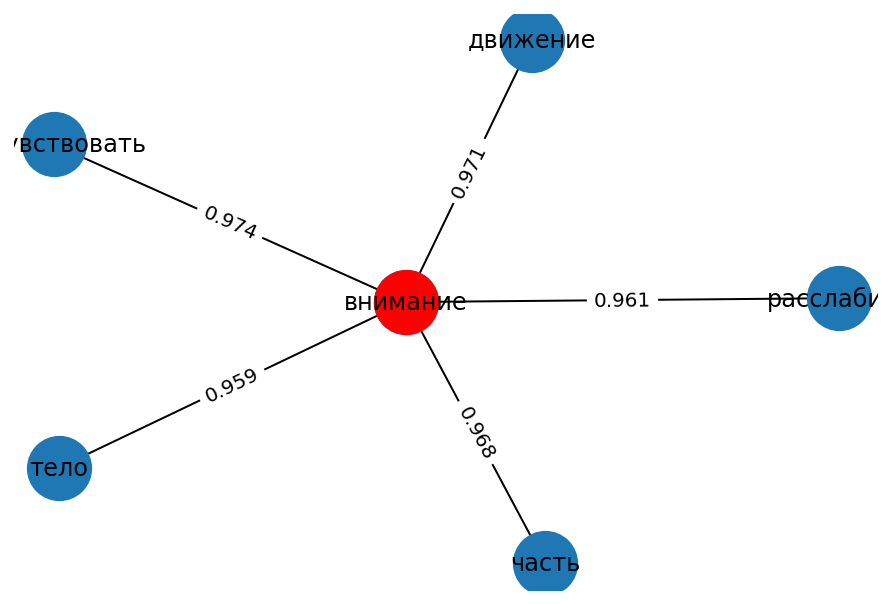

In [99]:
build_graph('внимание')

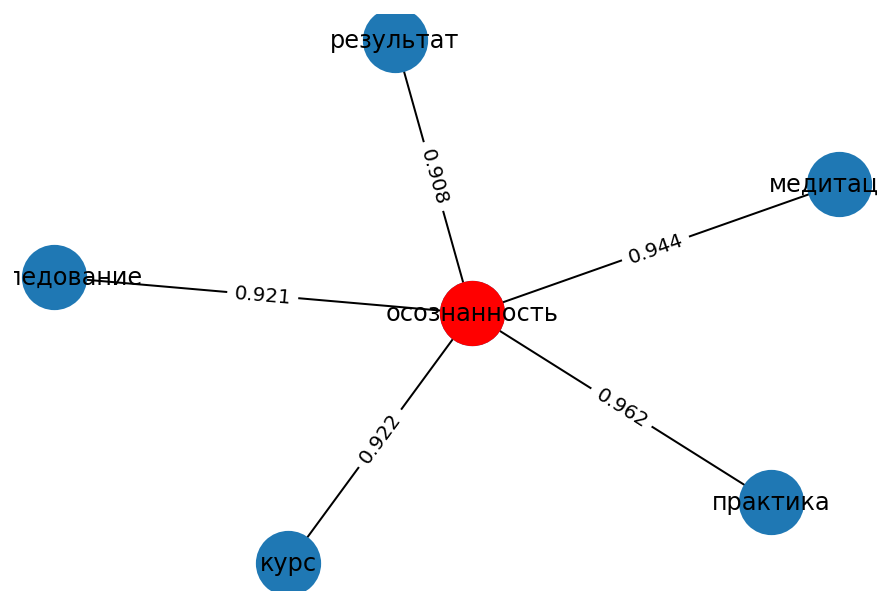

In [95]:
build_graph('осознанность')

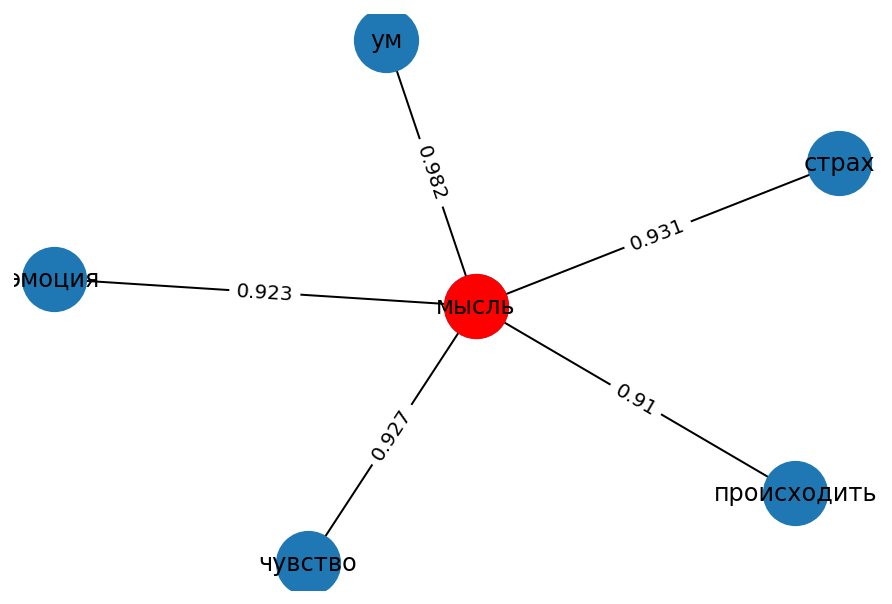

In [97]:
build_graph('мысль')